# **Exercise 1: Analyzing Energy Performance of Buildings**

## Overview

In this exercise, we analyze the [Energy Performance Certificate (EPC) dataset](https://epc.opendatacommunities.org/domestic/search) of individual dwellings in England and Wales. The EPC dataset records the *modelled* energy performance at the time of assessment, with each row corresponding to a single certificate issued following a standardised survey and calculation procedure, called [Standard Assessment Procedure (SAP)](https://www.gov.uk/guidance/standard-assessment-procedure). EPCs are model-based estimates under standard assumptions about weather, occupancy, and use, and *do not represent measured energy use*. EPC outputs are primarily designed for homeowners, renters, and policymakers.

By the end of this exercise, you should be able to:
- Process, visualize, and interpret building EPC data.
- Use descriptive/predictive analytics to identify the main factors that drive EPC ratings. 

## Set up

Load the required Python libraries and the data set. The data set contains information from 5000 buildings located in the London borough of Islington and is stored ```...\data raw\epc-certificates-Islington```; file ```certificates.csv``` contains the data and ```columns.csv``` explains the colunm headers. To load the data, update the ```path``` variable to the local folder location. 

For simplicity, columns with ```NaN``` values are dropped. An auxiliary function that estimates predictive accuracy, namely, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE), is provided.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_metrics(actual, predictions):
    ''' Estimate predictive accuracy metrics '''
    actual_copy = actual.copy().reshape(-1,1)
    predictions_copy = predictions.copy().reshape(-1,1)
    
    error = actual_copy - predictions_copy    
    assert(error.shape[0] == len(actual_copy))
    if error.ndim > 1:        
        assert(error.shape[1] == 1)

    mse = np.square(error).mean()
    rmse = np.sqrt( mse )
    mae = np.abs(error).mean()
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    return rmse, mae

# default settings for plots
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,3)

# load data
# !!!! Update the path variable
path = r'C:\Users\ucbva19\Git projects\BENV0092\data raw\epc-certificates-Islington'
df = pd.read_csv(f"{path}\\certificates.csv")  # change path

print(df.isna().sum())
display(df.head(3))

# drop columns with NaNs
df = df.dropna(axis=1)

assert(df.isna().sum().sum() == 0)

LMK_KEY                            0
ADDRESS1                           0
ADDRESS2                        1726
ADDRESS3                        3547
POSTCODE                           0
                                ... 
FIXED_LIGHTING_OUTLETS_COUNT       0
LOW_ENERGY_FIXED_LIGHT_COUNT    5000
UPRN                             671
UPRN_SOURCE                      671
REPORT_TYPE                        0
Length: 93, dtype: int64


,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,REPORT_TYPE
0,05a4e13c8f8892b40f457e58195271839c253e738b2a4a...,Flat A,32 Hanley Road,NaN,N4 3DR,10008499045,D,C,68,77,...,NaN,LONDON,England and Wales: 1900-1929,2025-11-30 22:21:53,Rented (social),10,NaN,5.300040e+09,Energy Assessor,100
1,07c0c456133427557a94e545821381d14767982acbf6cb...,Flat 17,Park Gate House 250-252,Seven Sisters Road,N4 2HU,10003804896,B,B,82,82,...,NaN,LONDON,England and Wales: 2003-2006,2025-11-30 20:48:23,Owner-occupied,6,NaN,5.300104e+09,Energy Assessor,100
2,09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...,Flat 13,Park Gate House 250-252,Seven Sisters Road,N4 2HU,10007227906,B,B,84,84,...,NaN,LONDON,England and Wales: 2003-2006,2025-11-30 20:47:40,Owner-occupied,6,NaN,5.300104e+09,Energy Assessor,100


## Preliminary analysis

As an example of preliminary analysis, we generate a few informative plots and descriptive statistics.

count    5000.000000
mean      177.686200
std       101.079758
min       -14.000000
25%       134.000000
50%       167.000000
75%       206.000000
max      5365.000000
Name: ENERGY_CONSUMPTION_CURRENT, dtype: float64
count    5000.00000
mean      593.40980
std       412.83544
min        37.00000
25%       354.00000
50%       493.00000
75%       699.00000
max      4787.00000
Name: HEATING_COST_CURRENT, dtype: float64
count     5000
unique       6
top          C
freq      3120
Name: CURRENT_ENERGY_RATING, dtype: object


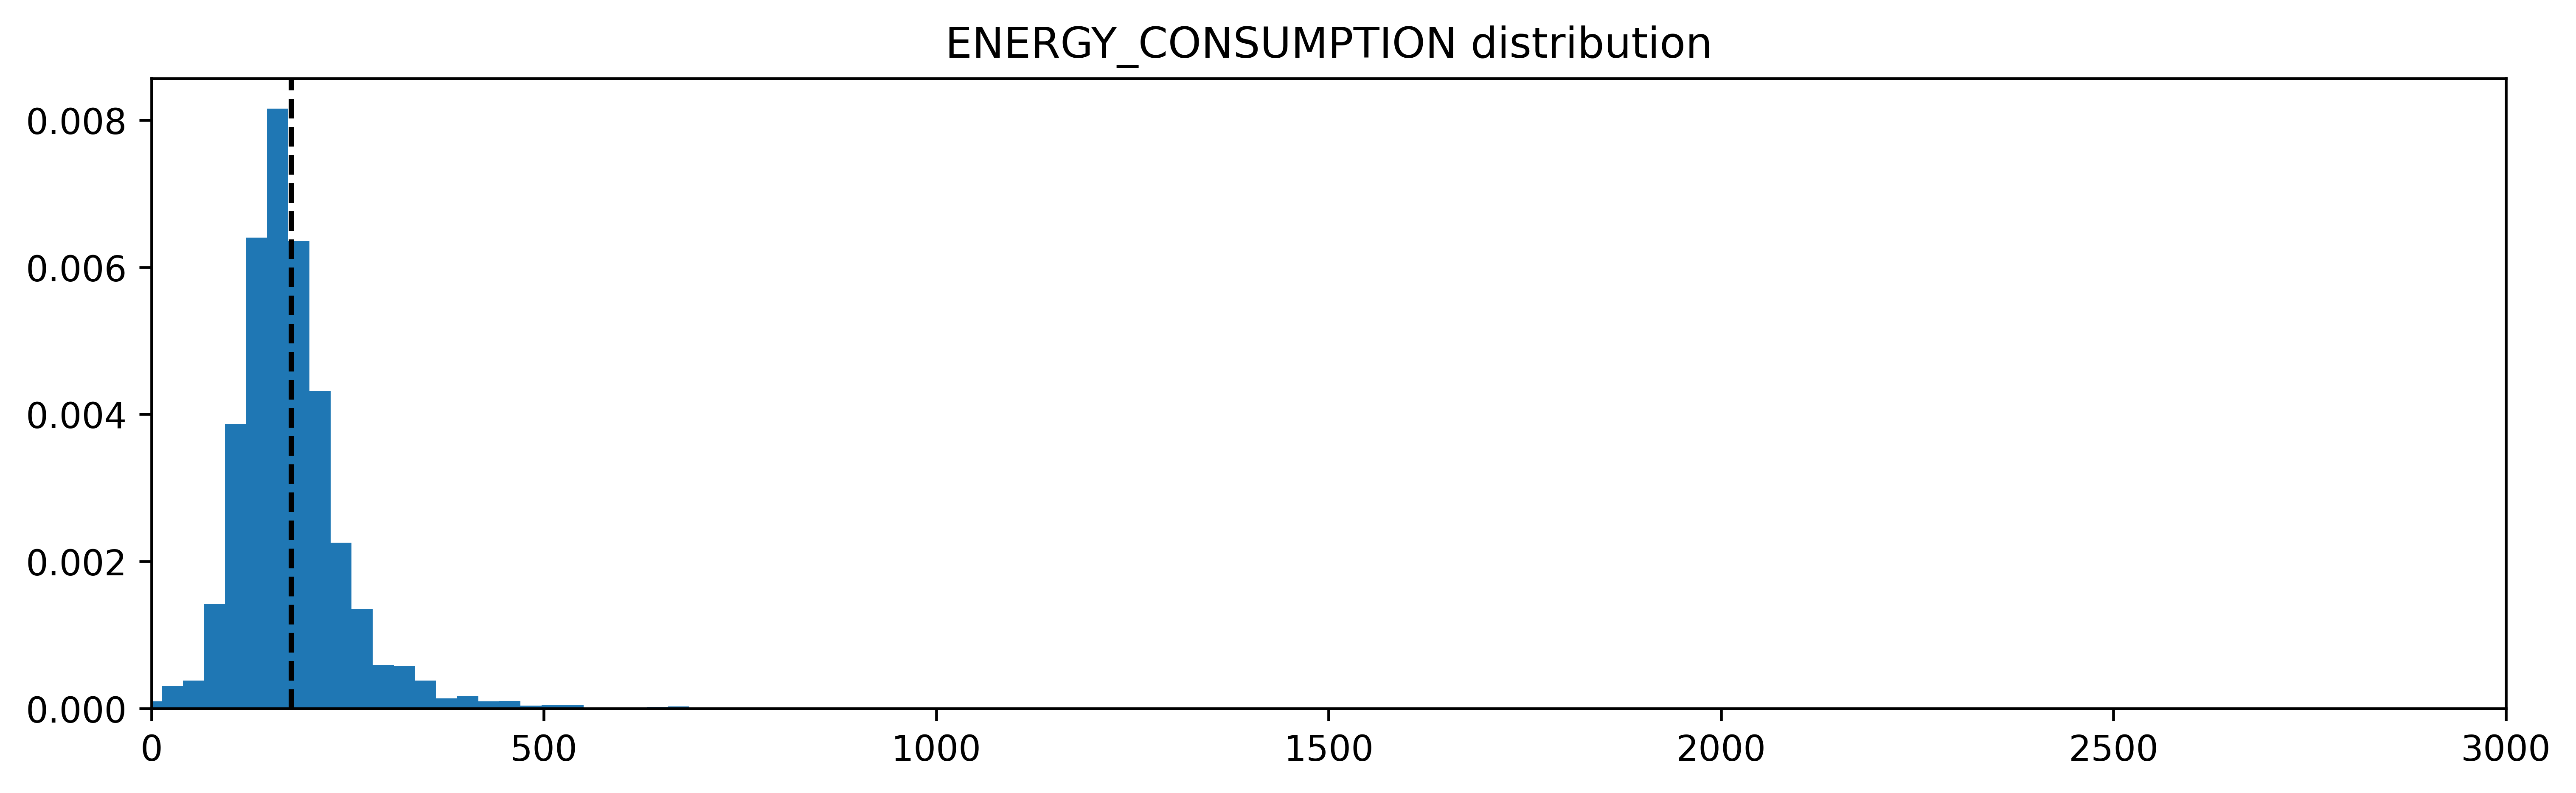

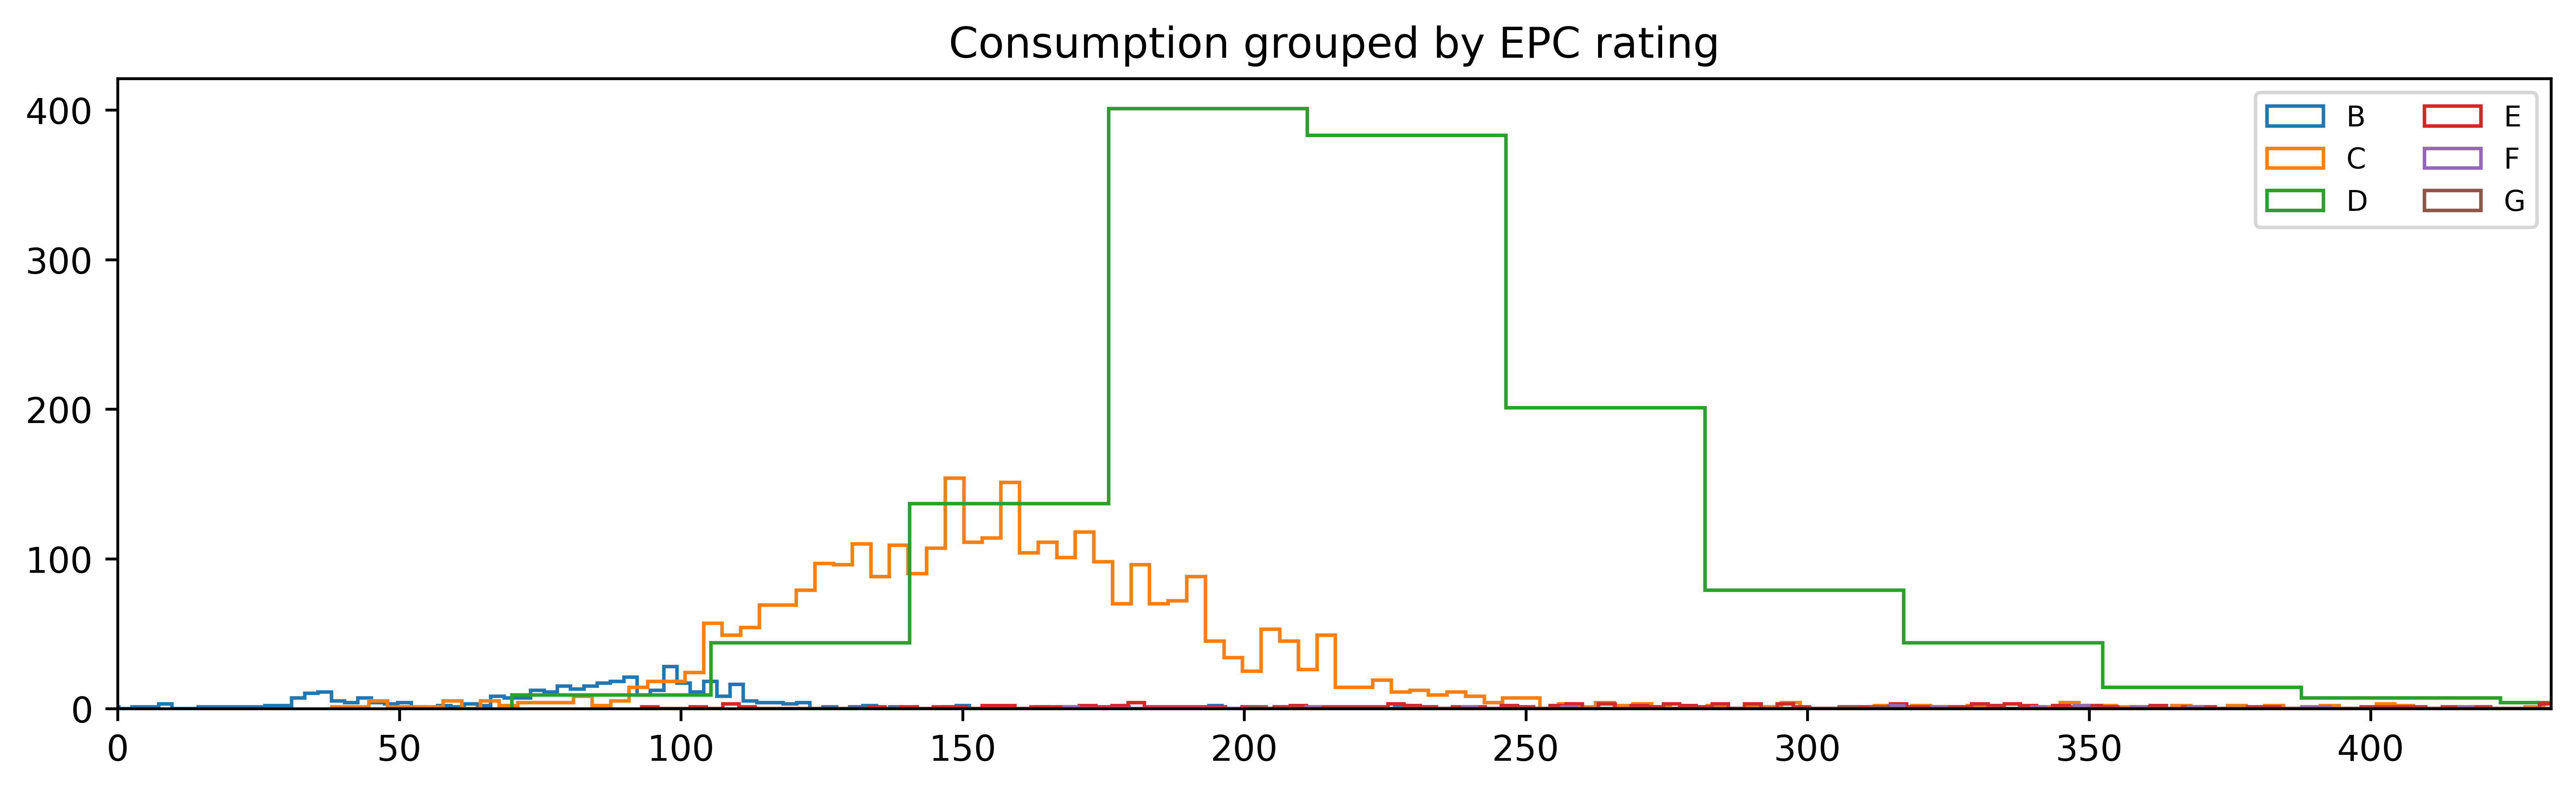

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_11664\2835056043.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = cats, showfliers=False)


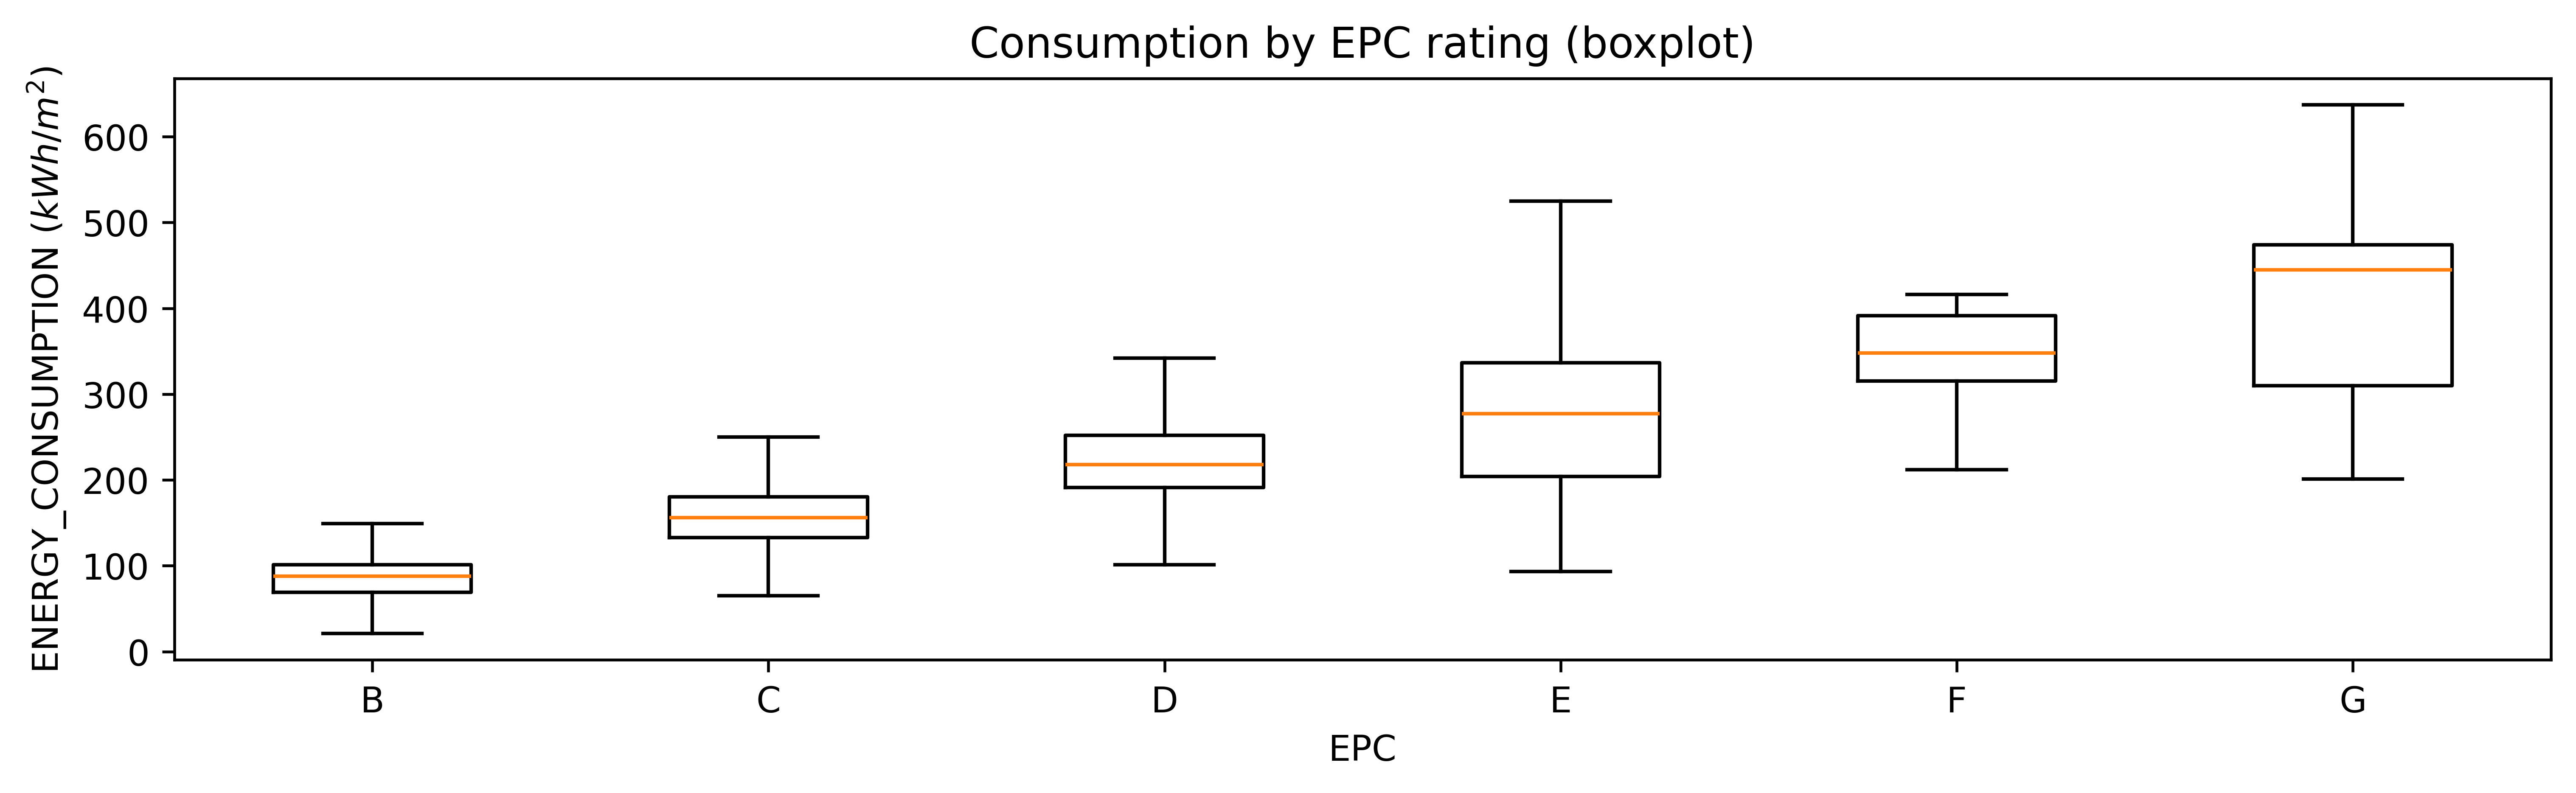

In [2]:
# Descriptive statistics
print(df['ENERGY_CONSUMPTION_CURRENT'].describe())
print(df['HEATING_COST_CURRENT'].describe())
print(df['CURRENT_ENERGY_RATING'].describe())

# Plot distribution
plt.figure()
plt.hist(df["ENERGY_CONSUMPTION_CURRENT"], bins=200, density=True)
plt.axvline(df["ENERGY_CONSUMPTION_CURRENT"].mean(), linestyle="--", color = 'black')
plt.xlim(0, 3000)
plt.title("ENERGY_CONSUMPTION distribution")
plt.show()


# EPC rating counts
plt.figure()
for k, g in df.groupby("CURRENT_ENERGY_RATING"):
    plt.hist(g["ENERGY_CONSUMPTION_CURRENT"], bins=150, histtype="step", label=str(k))
plt.xlim(0, df["ENERGY_CONSUMPTION_CURRENT"].quantile(0.99))
plt.title("Consumption grouped by EPC rating")
plt.legend(ncol=2, fontsize=8)
plt.show()

# Boxplot by EPC
plt.figure()
cats = sorted(df["CURRENT_ENERGY_RATING"].dropna().unique())
data = [df.loc[df["CURRENT_ENERGY_RATING"] == c, "ENERGY_CONSUMPTION_CURRENT"].values for c in cats]
plt.boxplot(data, labels = cats, showfliers=False)
plt.title("Consumption by EPC rating (boxplot)")
plt.xlabel("EPC")
plt.ylabel("ENERGY_CONSUMPTION $(kWh/m^2)$")
plt.show()

## Which factors drive EPC ratings?

Our main task is to analyze the factors that drive EPC ratings. We will use ```CURRENT_ENERGY_EFFICIENCY``` as the target/ outcome variable, which is a dimensionless variable that takes values in the range $(0,100)$, where $100$ indicates the most efficient dwelling (effectively, zero energy costs).

You may use any descriptive or predictive analytics method that you consider appropriate. There are multiple ways to tackle this problem. For instance, you can apply linear regression analysis and conduct statistical tests or train predictive machine learning (ML) models and calculate feature importance metrics, such as Shapley values.

#### Avoiding data leakage

Several variables in this dataset are model outputs, i.e., they are computed from the model itself. Using them as predictors should be avoided as it creates data leakage and circular logic. It is suggested to focus on features that relate to building characteristics, such as built form, fabric, services, and so forth. 

Here is a list of recommended features (feel free to include more):
- Built form: ```TOTAL_FLOOR_AREA```, ```PROPERTY_TYPE```, ```BUILT_FORM```, and ```FLOOR_HEIGHT```
- Envelope: ```WALLS_ENERGY_EFF``` and ```WINDOWS_ENERGY_EFF```
- Heating and hot water: ```MAINHEAT_ENERGY_EFF``` and ```HOT_WATER_ENERGY_EFF```
- Lighting and auxiliary: ```LIGHTING_ENERGY_EFF```, ```FIXED_LIGHTING_OUTLETS_COUNT``` and ```LOW_ENERGY_LIGHTING```

Note that variables such as ```WALLS_ENERGY_EFF``` or ```MAINHEAT_ENERGY_EFF``` are categorical SAP-derived efficiency bands (e.g. Poor / Average / Good), not measured efficiencies.

Variables about efficiency, rating, costs, or counterfactuals (marked with ```POTENTIAL```) *should not* be used as predictors. For instance, do not use ```CURRENT_ENERGY_EFFICIENCY, CURRENT_ENERGY_RATING, ENERGY_CONSUMPTION_CURRENT, CO2_EMISSIONS_CURRENT, ENVIRONMENT_IMPACT_CURRENT, HEATING_COST_CURRENT, HOT_WATER_COST_CURRENT, LIGHTING_COST_CURRENT, POTENTIAL_ENERGY_EFFICIENCY, POTENTIAL_ENERGY_RATING, ENERGY_CONSUMPTION_POTENTIAL``` and ```CO2_EMISSIONS_POTENTIAL```.

In [3]:
target_variable = 'CURRENT_ENERGY_EFFICIENCY'
feature_list = ['TOTAL_FLOOR_AREA', 'PROPERTY_TYPE', 'BUILT_FORM',
                'WALLS_ENERGY_EFF', 'WINDOWS_ENERGY_EFF', 
                'MAINHEAT_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF',
                'LIGHTING_ENERGY_EFF', 'FIXED_LIGHTING_OUTLETS_COUNT', 'LOW_ENERGY_LIGHTING']

Y = df[target_variable]
X = df[feature_list]

# print out categories for categorical features
for c in feature_list:
    if pd.api.types.is_string_dtype(df[c]): 
        print(f'Feature: {c}')
        print(f'Categories: {X[c].unique()}')

Feature: PROPERTY_TYPE
Categories: ['Flat' 'Maisonette' 'House' 'Bungalow']
Feature: BUILT_FORM
Categories: ['Not Recorded' 'Mid-Terrace' 'Semi-Detached' 'End-Terrace'
 'Enclosed End-Terrace' 'Enclosed Mid-Terrace' 'Detached']
Feature: WALLS_ENERGY_EFF
Categories: ['Poor' 'Good' 'Average' 'Very Poor' 'Very Good']
Feature: WINDOWS_ENERGY_EFF
Categories: ['Good' 'Very Poor' 'Average' 'Poor' 'Very Good']
Feature: MAINHEAT_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: HOT_WATER_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: LIGHTING_ENERGY_EFF
Categories: ['Good' 'Average' 'Poor' 'Very Poor' 'Very Good']


### Solution: Tree-based regression + Permutation Importance

We approach this problem using an ML predictor and estimating the importance of each feature. For this example, we choose the ```ExtraTreesRegressor``` predictor from the ```sklearn``` library and estimate the [Permutation Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) metric, which is a modeling inspection method that works with any trained predictor. An illustrative example and explanation can be found [here](https://scikit-learn.org/stable/modules/permutation_importance.html). In short, given a trained model, each feature (column) observation is randomly shuffled (permutated) and predictive performance is evaluated on a hold-out set. The shuffling process resembles adding noise and renders each feature effectively useless; the expected decrease in predictive accuracy is a good proxy for the importance of each feature.

The code below implements the following steps:
- Features are seperated into numerical, categorical, and ordinal features. Categorical features are one-hot encoded using ```OneHotEncoder``` and ordinal features are encoded using ```OrdinalEncoder```.
- To streamline the preprocessing, a ```ColumnTransformer``` and a ```Pipeline``` object are created.
- Data are split into train/test set and the ExtraTree regressor is trained.
- The Permutation Importance method is applied.

Tree-based methods estimate an internal feature importance metric during training, based on expected error reduction when splitting an internal node, which is plotted as well.  However, this metric is known to be biased. Comparing the two plots, we observe that the most important feature differs from the one obtained using the Permutation Importance metric.

Evaluate model on out-of-sample data
MSE: 34.5532123404102
RMSE: 5.878198052159369
MAE: 4.033059635532818


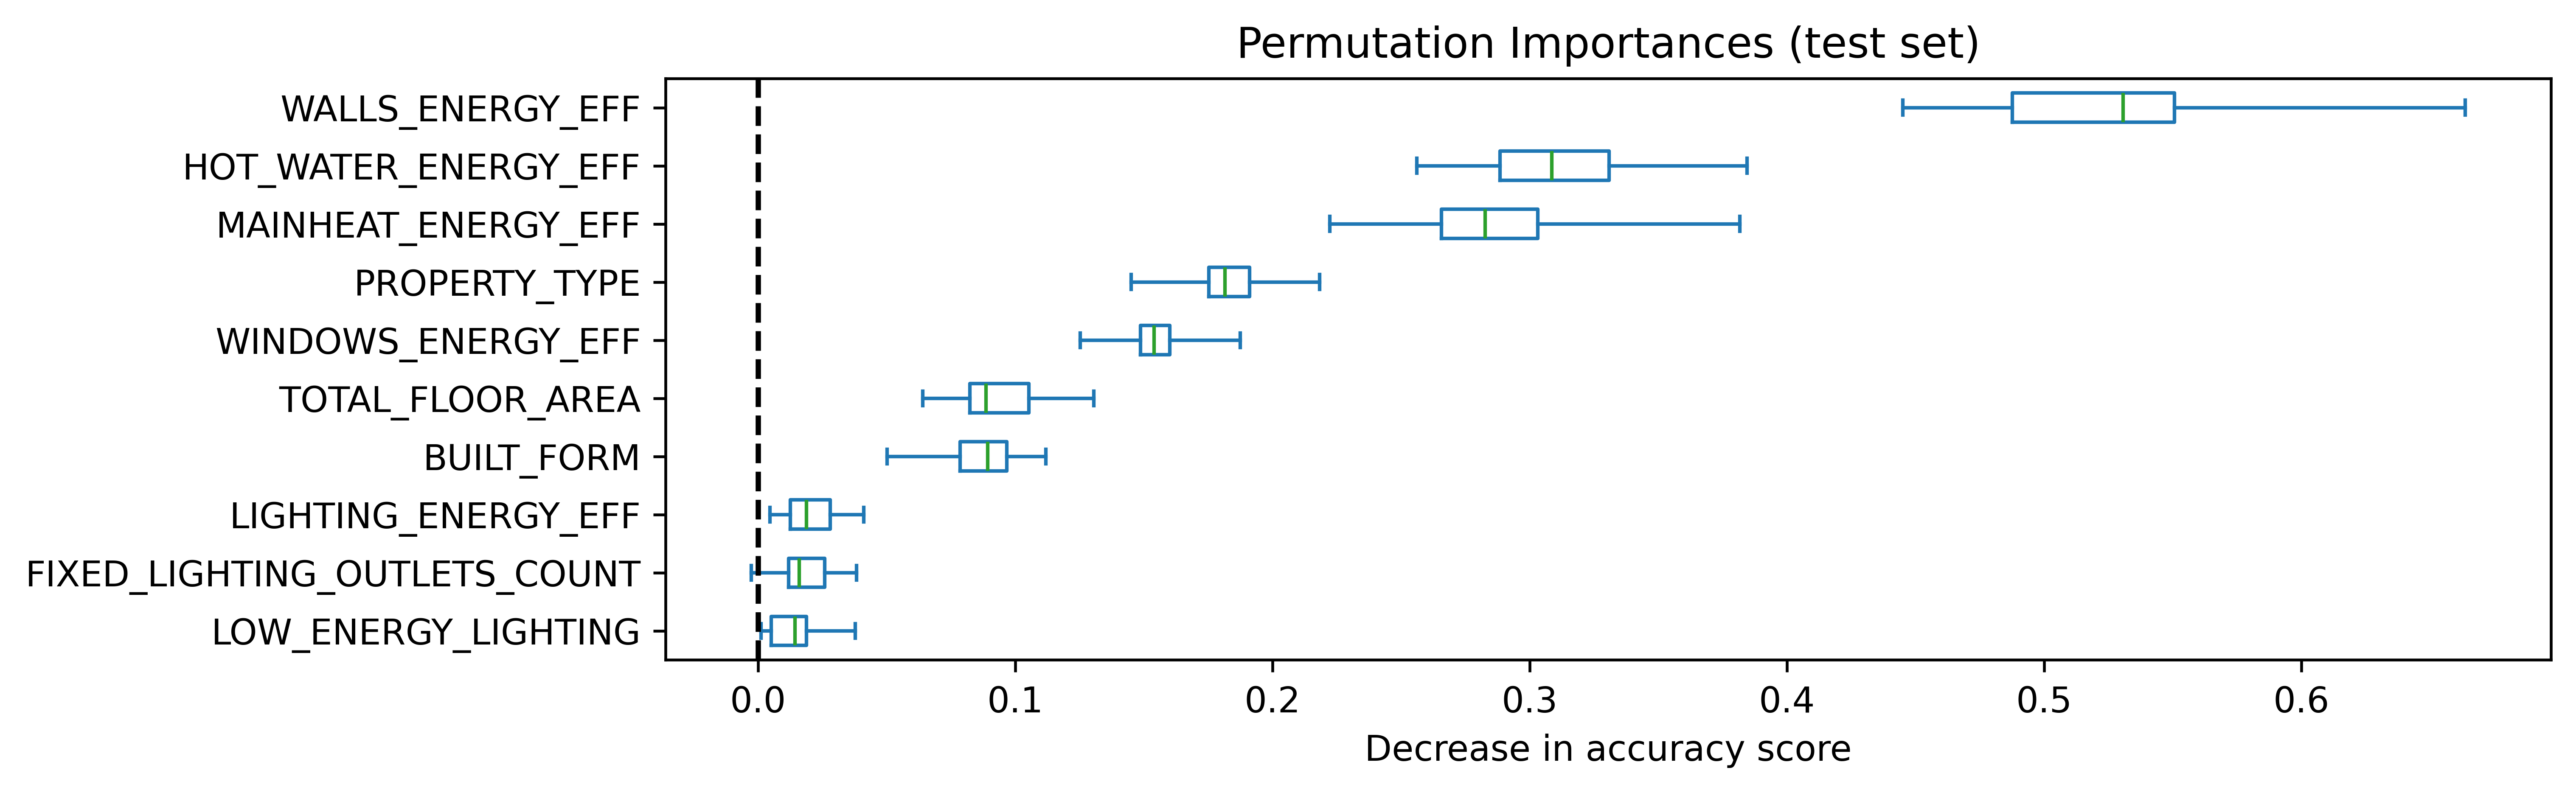

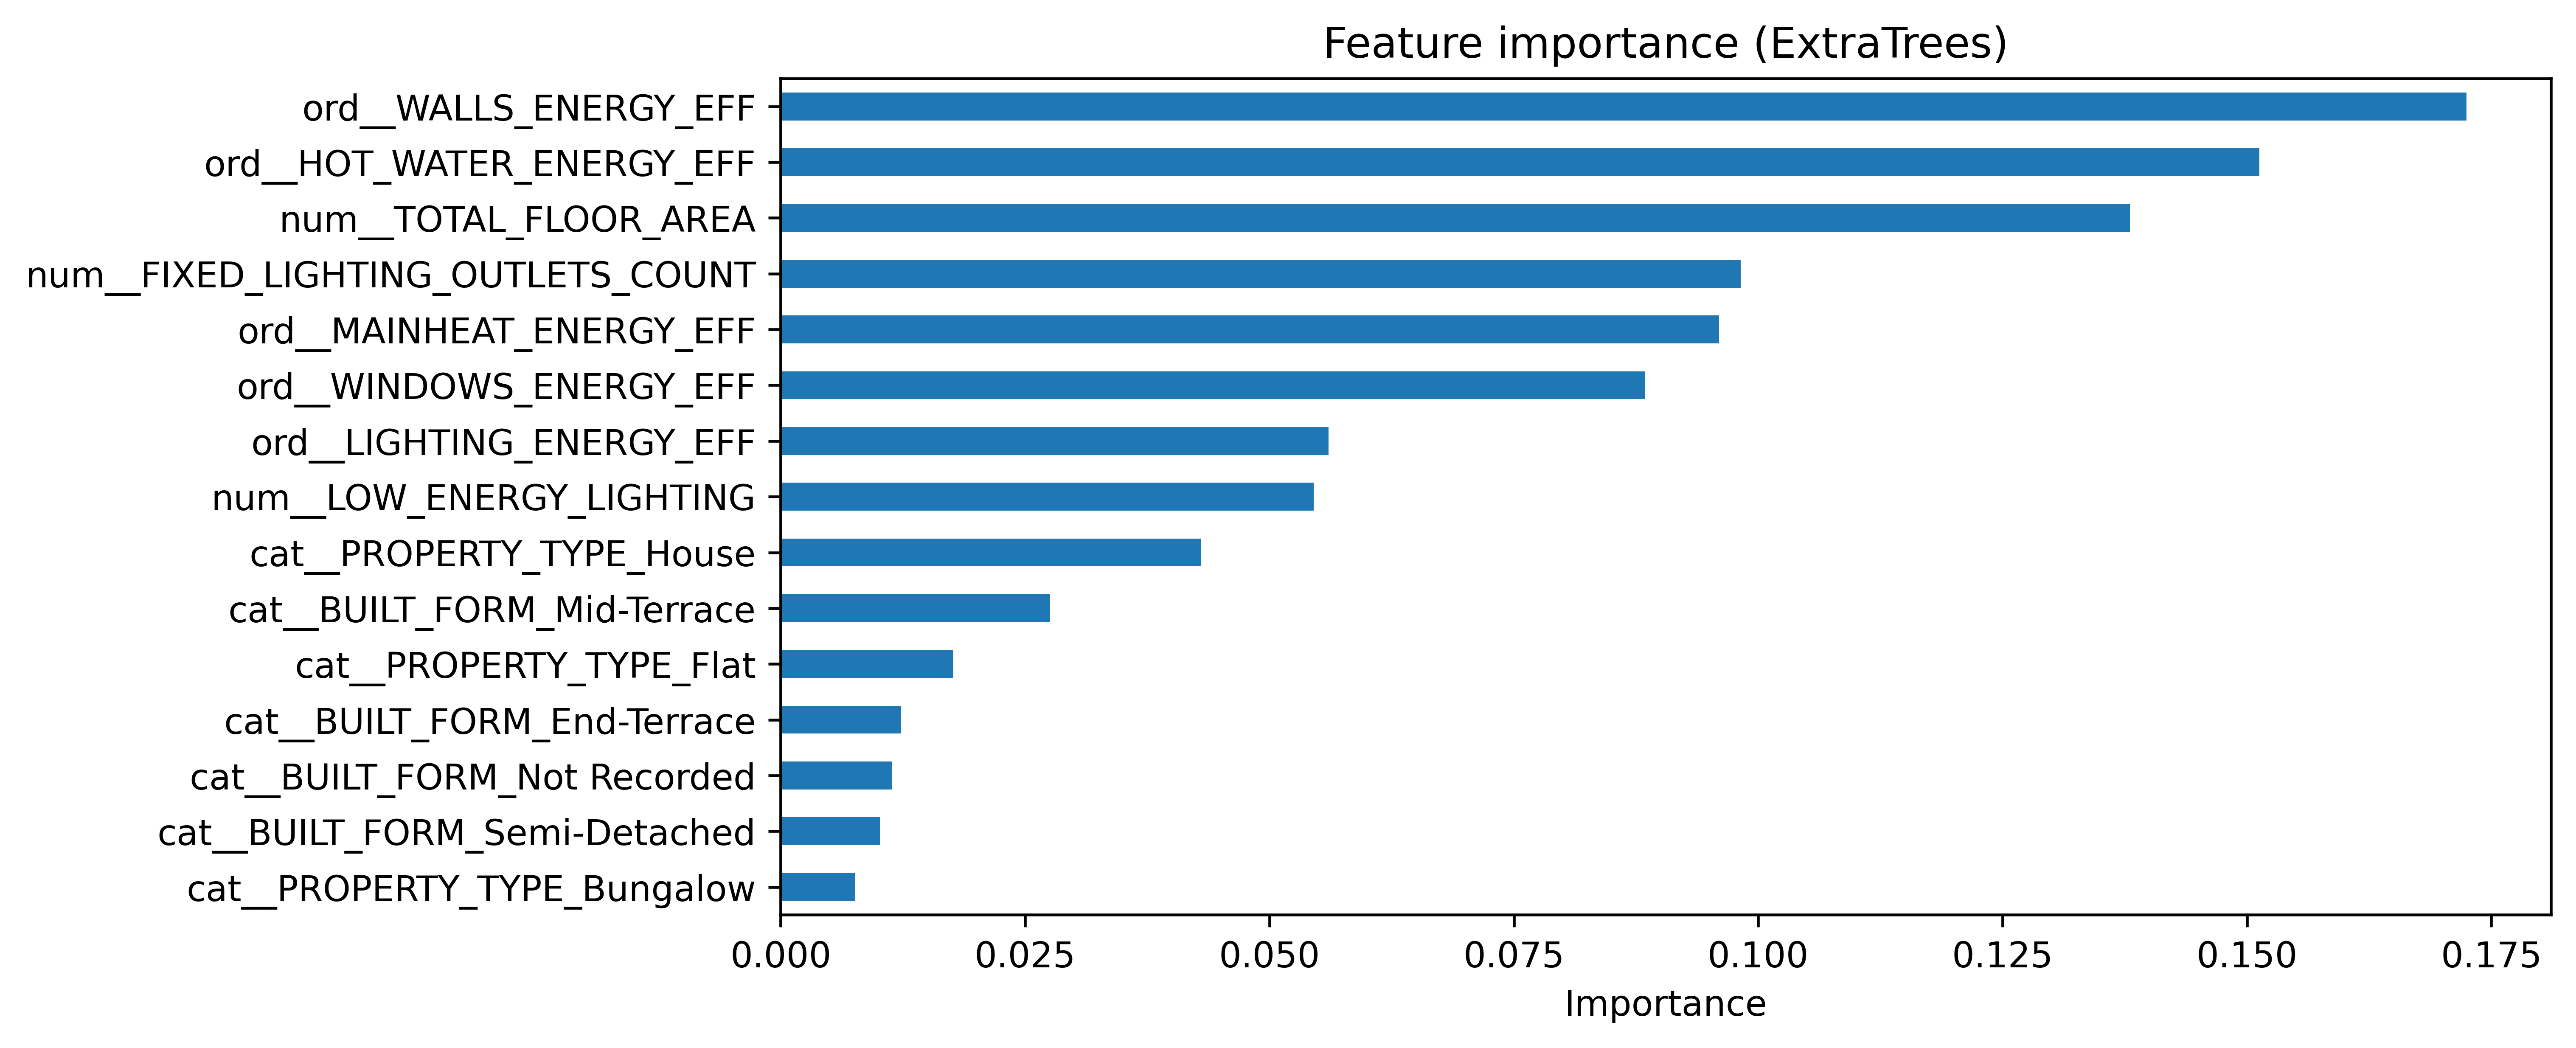

In [4]:
#%% Step 1: Pre-process and fit regression model

# Load libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance

target_variable = 'CURRENT_ENERGY_EFFICIENCY'

# further separate features into numerical, categorical, and ordinal
numerical_features = ['TOTAL_FLOOR_AREA', 'FIXED_LIGHTING_OUTLETS_COUNT', 'LOW_ENERGY_LIGHTING']
ordinal_features = ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF']
categorical_features = ['PROPERTY_TYPE', 'BUILT_FORM']

feature_list = numerical_features + ordinal_features + categorical_features

Y = df[target_variable]
X = df[feature_list]

# Training/ test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)

# Preprocessing
categories_list = [df['PROPERTY_TYPE'].unique(), df['BUILT_FORM'].unique()]

ord_list =   [['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'] for feat in ordinal_features]

# create a preprocessor that implements one-hot and ordinal encoding
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                  ("ord", OrdinalEncoder(categories = ord_list), ordinal_features),
                  ("num", "passthrough", numerical_features),])

# ExtraTree Model pipeline
et_model = Pipeline(
    steps=[("preprocess", preprocessor), ("regressor", ExtraTreesRegressor()),])

et_model.fit(train_X, train_Y)
y_et_pred = et_model.predict(test_X)

# evaluate accuracy
print('Evaluate model on out-of-sample data')
_, _ = accuracy_metrics(test_Y.values, y_et_pred)

# Permutation importance
r = permutation_importance(et_model, test_X, test_Y, n_repeats=30, random_state=0)
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame( r.importances[sorted_importances_idx].T, columns = X.columns[sorted_importances_idx],)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
plt.show()

# Feature importance (default estimation in tree-based algorithms)
# get feature names after one-hot encoding
feature_names = et_model.named_steps["preprocess"].get_feature_names_out()
importances = et_model.named_steps["regressor"].feature_importances_

fi = pd.Series(importances, index = feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
fi.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature importance (ExtraTrees)")
plt.xlabel("Importance")
plt.show()

Both approaches indicate that ```WALLS_ENERGY_EFF``` is the most important feature. Our results corroborate findings from existing studies. For instance, [1] finds that external wall U-value and dwelling geometry account for 75% of the variance of the energy rating of gas central-heated houses in England.

#### References

1. Stone, A., Shipworth, D., Biddulph, P. and Oreszczyn, T., 2014. Key factors determining the energy rating of existing English houses. Building Research & Information, 42(6), pp.725-738.